### Importing libraries

In [29]:
import pyreadr
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Input
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

### Importing Dataset

In [30]:
# Locating file in directories rather exposing the paths

import os


def search_file(start_dir, target_file):
    for dirpath, dirnames, filenames in os.walk(start_dir):
        if target_file in filenames:
            # print("Found {} at: {}".format(target_file, os.path.join(dirpath, target_file)))
            return os.path.join(dirpath, target_file)
    # print("File '{}' not found in '{}'".format(target_file, start_dir))
    return None


start_dir = "D:\\"

Fault_free_data = search_file(start_dir, "TEP_FaultFree_Training.RData")
Fault_data = search_file(start_dir, "TEP_Faulty_Training.RData")

In [31]:
df_FaultFree = pyreadr.read_r(Fault_free_data)['fault_free_training']
df_Faulty = pyreadr.read_r(Fault_data)['faulty_training']

In [32]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


### Preprocessing dataset

In [33]:
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
data = DF[DF['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = data[(data['faultNumber'] == 0)].iloc[:, 3:]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)


StandardScaler()

In [34]:
reduced_data = DF[(DF['simulationRun'] >= 1) & (DF['simulationRun'] <= 50)]
reduced_data = reduced_data[reduced_data['faultNumber'] != 3]
reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

X = sc.transform(reduced_data[reduced_data['sample']>20].iloc[:,3:])
Y = reduced_data[reduced_data['sample']>20]['faultNumber'].values

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(Y.reshape(-1, 1))

Y_enc = enc.transform(Y.reshape(-1, 1))

c:\Users\saif_\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42)

### Preparing neural network

In [36]:
# Define input layer
inputs = Input(shape=(x_train.shape[1],))

hidden_layer = Dense(100, activation='relu')(inputs)
hidden_layer = Dense(100, activation='relu')(hidden_layer)
outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the merged_model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense_3 (Dense)             (None, 100)               5300      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 18)                1818      
                                                                 
Total params: 17,218
Trainable params: 17,218
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
1350/1350 [==============================] - 5s 3ms/step - loss: 0.6837 - accuracy: 0.7938 - val_loss: 0.3606 - val_accuracy: 0.8962
Epoch 2/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.3001 - accuracy: 0.9142 - val_loss: 0.2669 - val_accuracy: 0.9244
Epoch 3/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.2477 - accuracy: 0.9280 - val_loss: 0.2347 - val_accuracy: 0.9321
Epoch 4/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.2238 - accuracy: 0.9338 - val_loss: 0.2196 - val_accuracy: 0.9351
Epoch 5/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.2105 - accuracy: 0.9374 - val_loss: 0.2131 - val_accuracy: 0.9371
Epoch 6/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.2028 - accuracy: 0.9394 - val_loss: 0.2065 - val_accuracy: 0.9388
Epoch 7/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1956 - accuracy: 0.9410 - val_loss: 0.1991 - val_ac

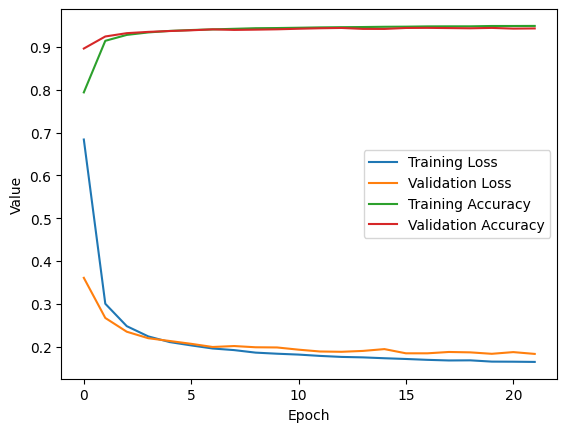

In [37]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [38]:
intermediate_model = Model(inputs=model.input,outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense_3 (Dense)             (None, 100)               5300      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
Total params: 15,400
Trainable params: 15,400
Non-trainable params: 0
_________________________________________________________________


In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
x_post_ann = intermediate_model.predict(x_train[::10])
y_rf_train = enc.inverse_transform(y_train[::10])

1080/1080 [==============================] - 1s 692us/step


### Training model


In [40]:
rf.fit(x_post_ann, y_rf_train)


C:\Users\saif_\AppData\Local\Temp\ipykernel_17992\1677848801.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_post_ann, y_rf_train)


RandomForestClassifier()

In [41]:
x_test_rf = intermediate_model.predict(x_test)
y_test_rf = enc.inverse_transform(y_test)
y_pred = rf.predict(x_test_rf)

2700/2700 [==============================] - 2s 847us/step


### Evaluating the model


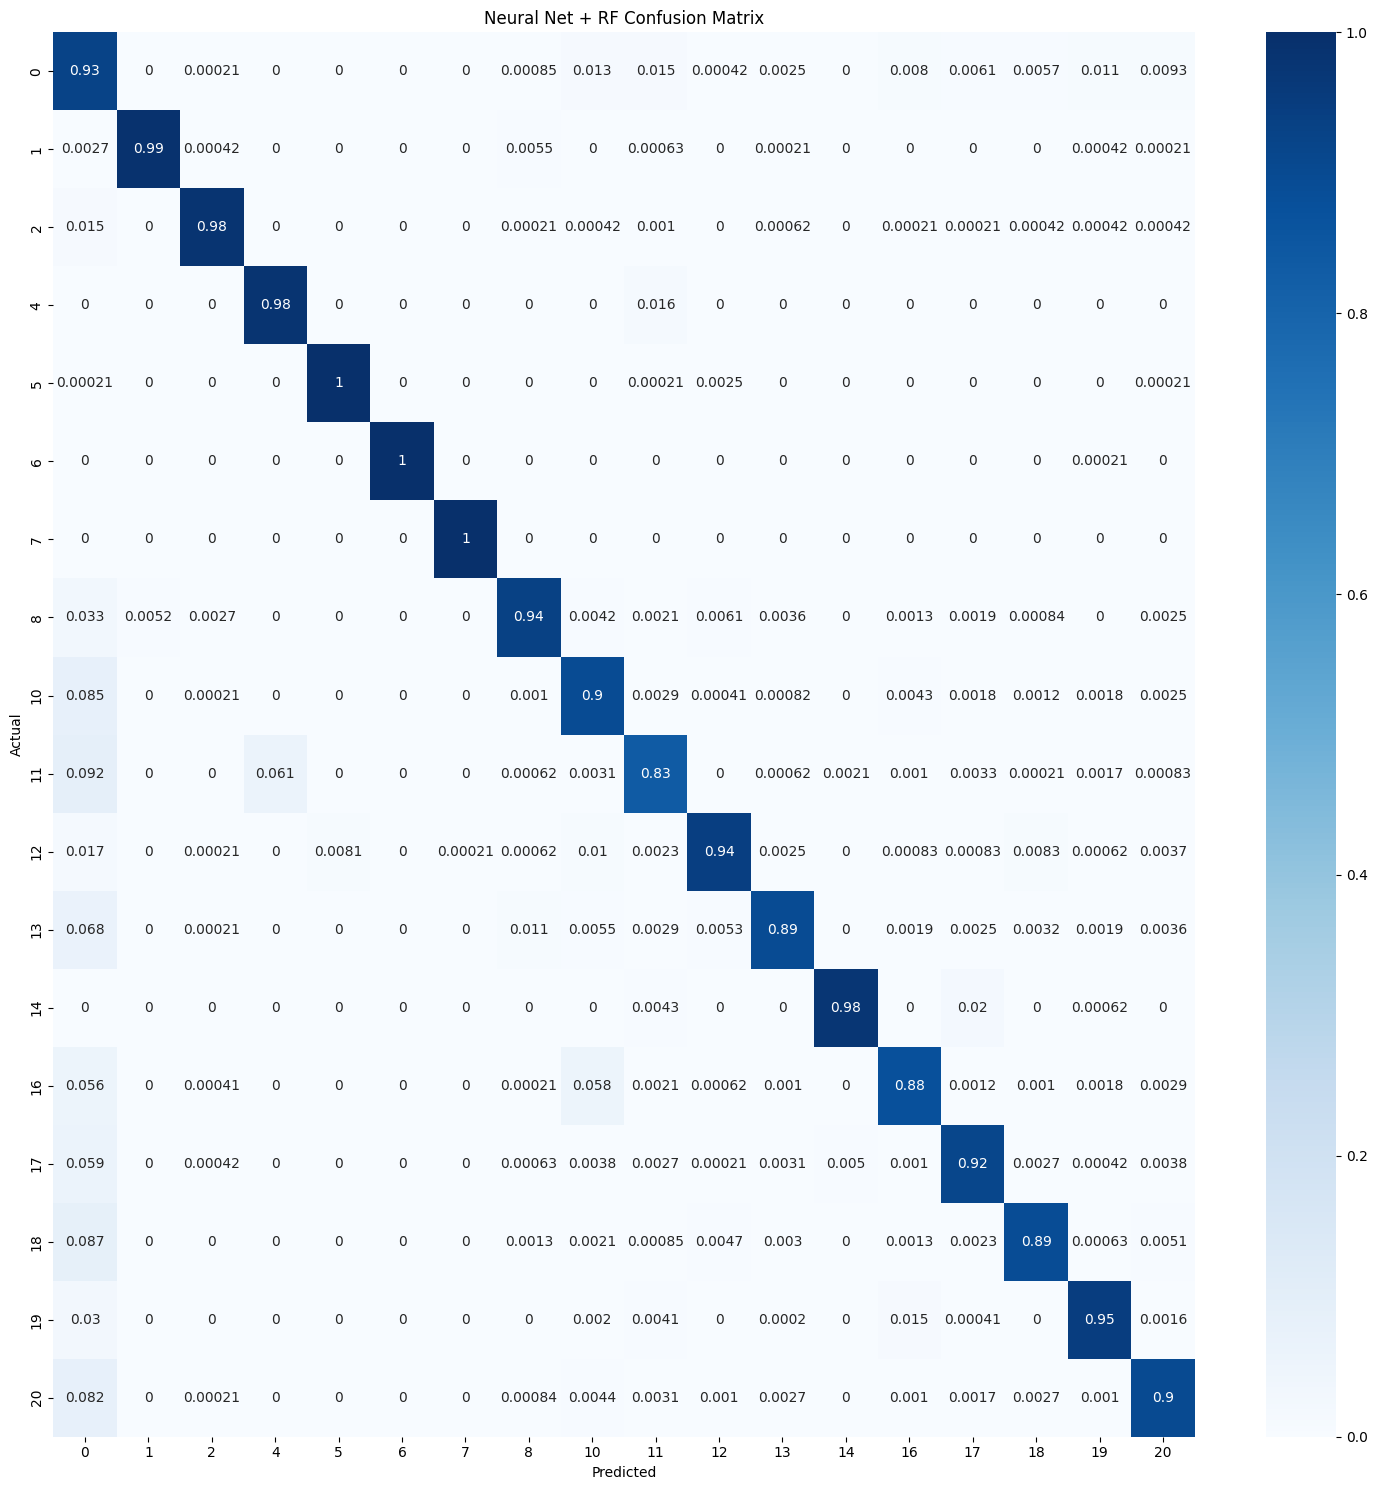

Neural Net + RF accuracy_score: 0.9382754629629629


In [42]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_yticklabels([str(x) for x in range(0,21) if x not in [3,9,15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_test_rf, y_pred, 'Neural Net + RF Confusion Matrix')
print("Neural Net + RF accuracy_score:", accuracy_score(y_test_rf, y_pred))

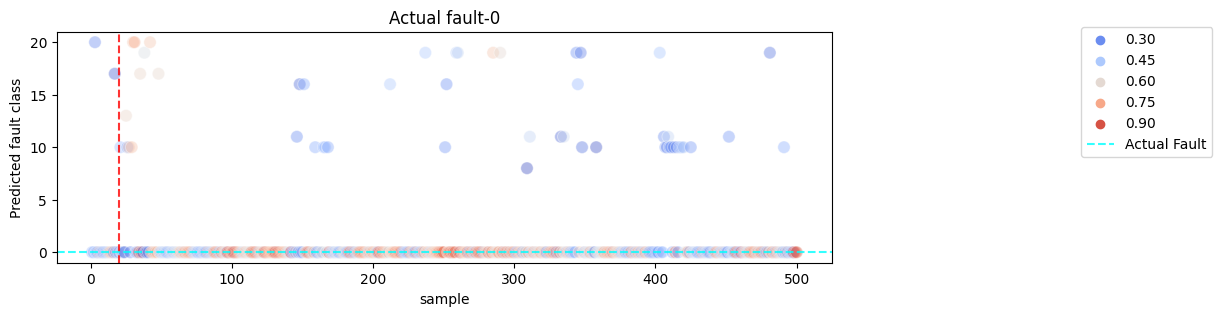

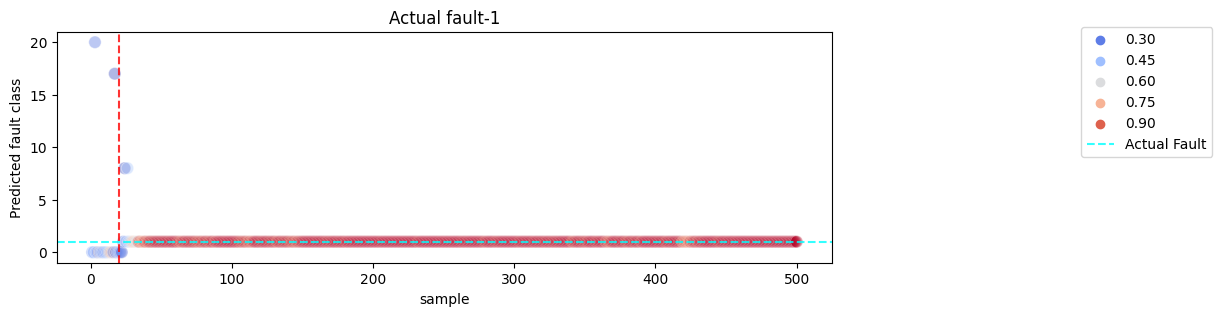

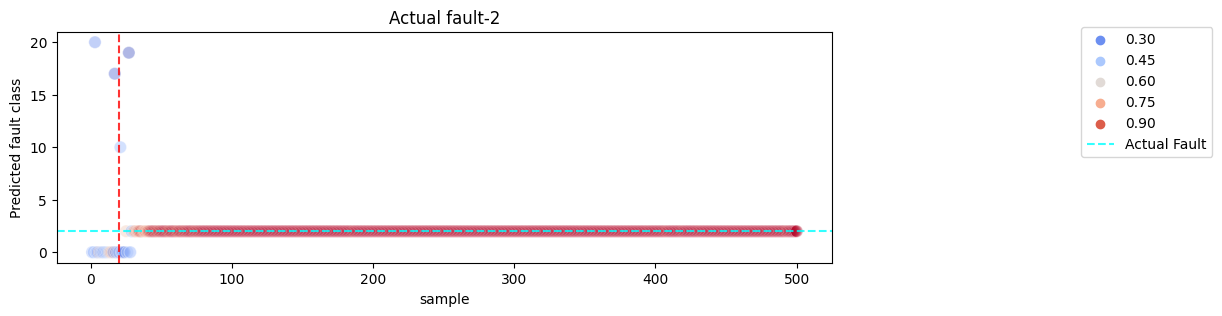

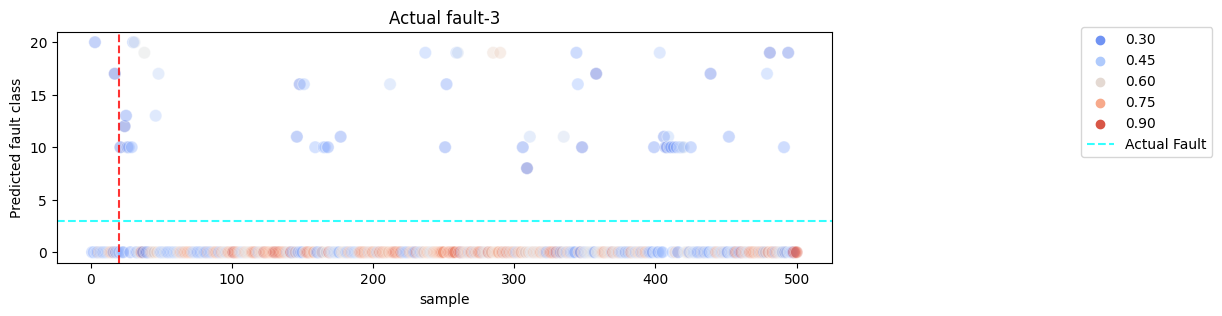

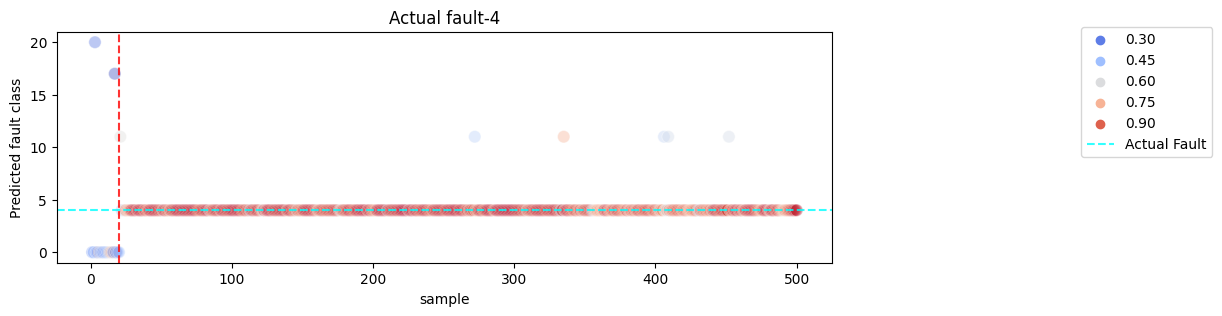

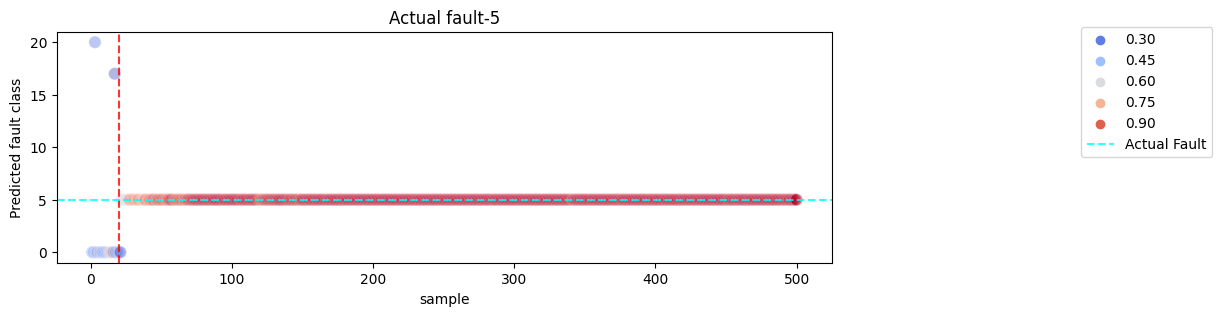

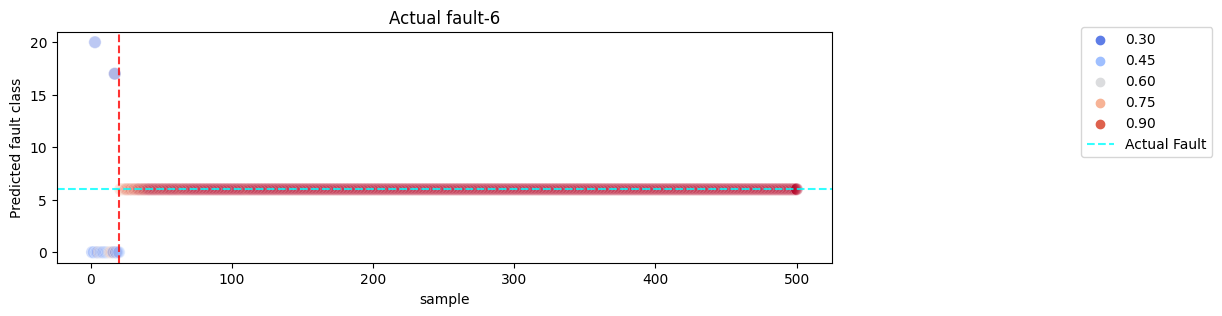

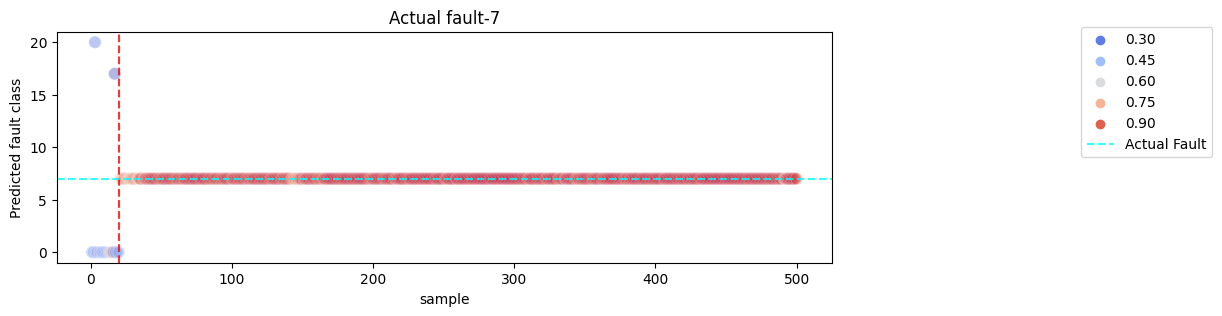

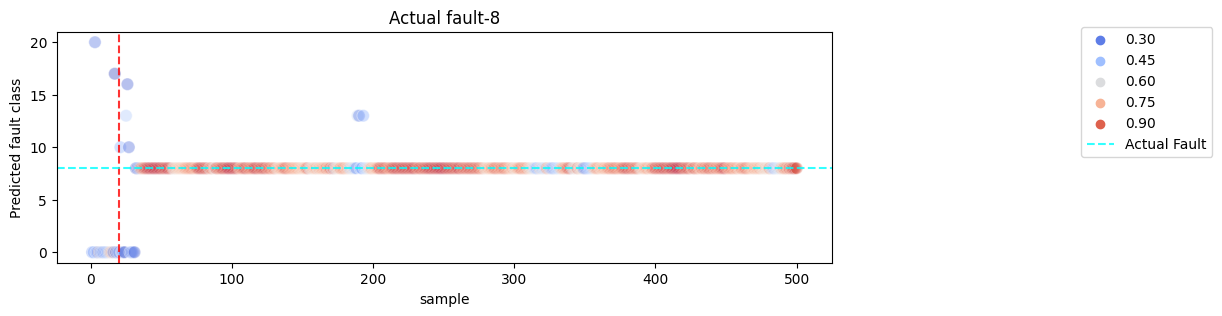

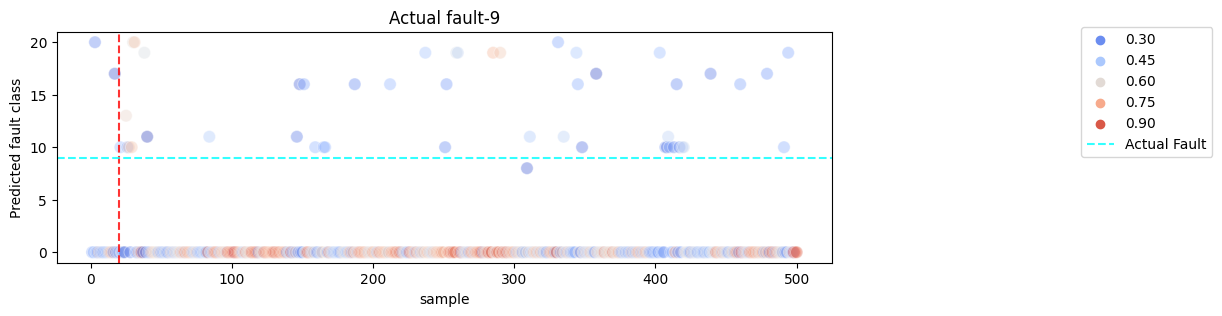

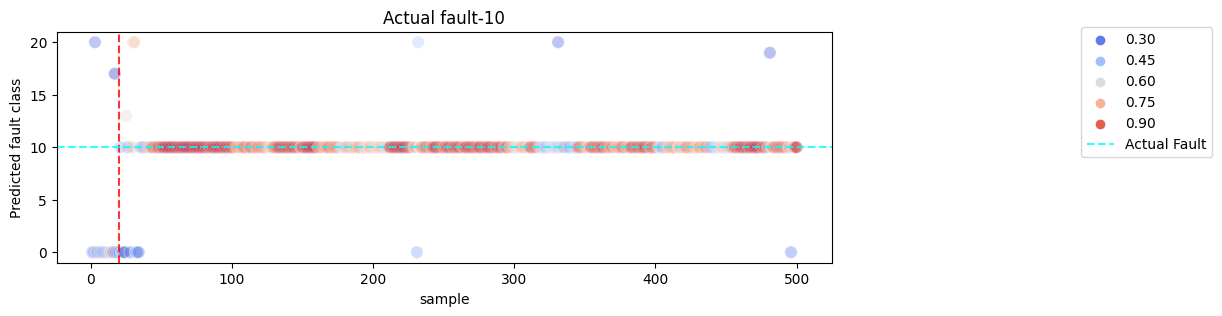

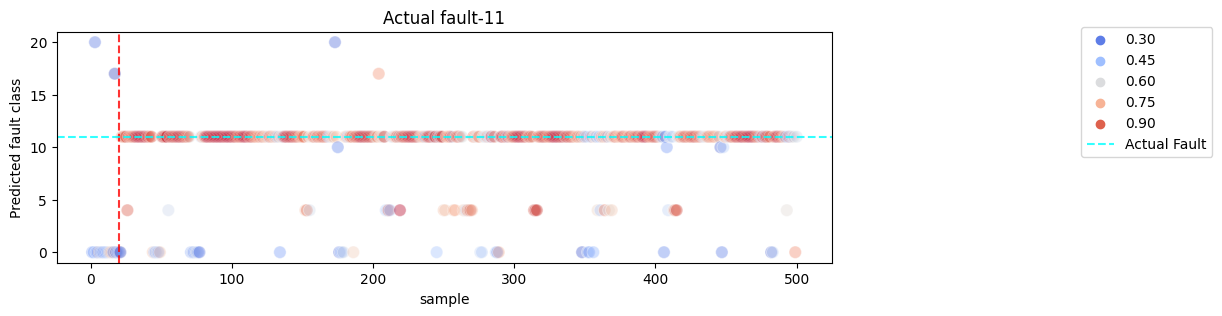

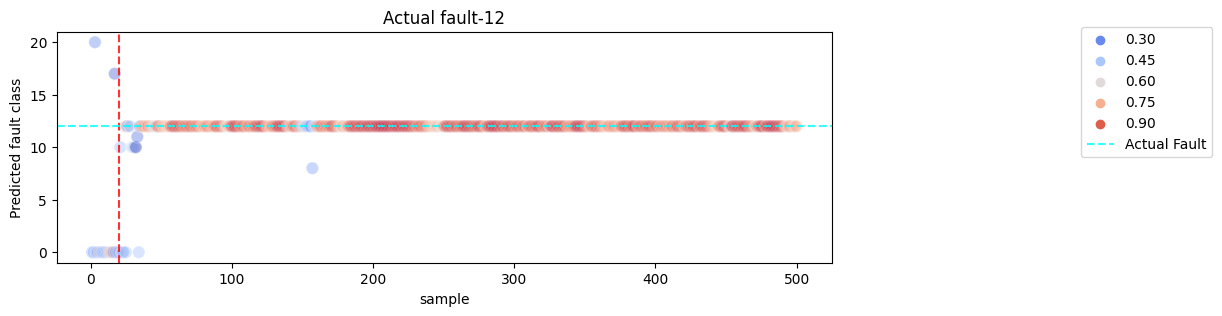

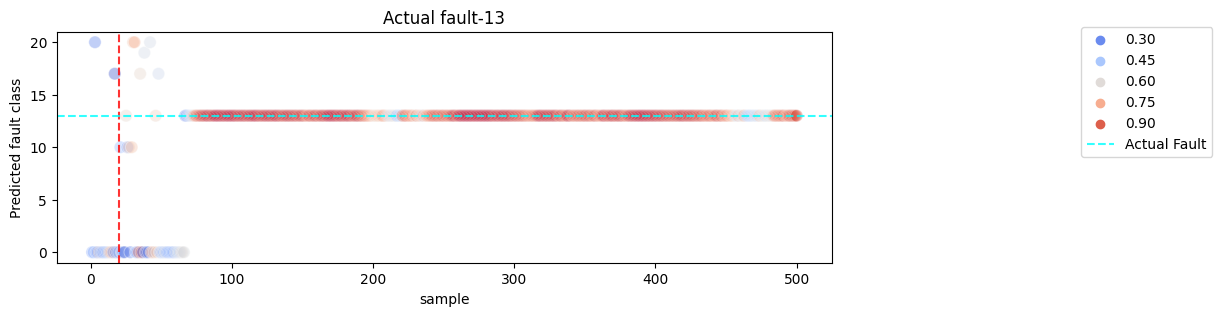

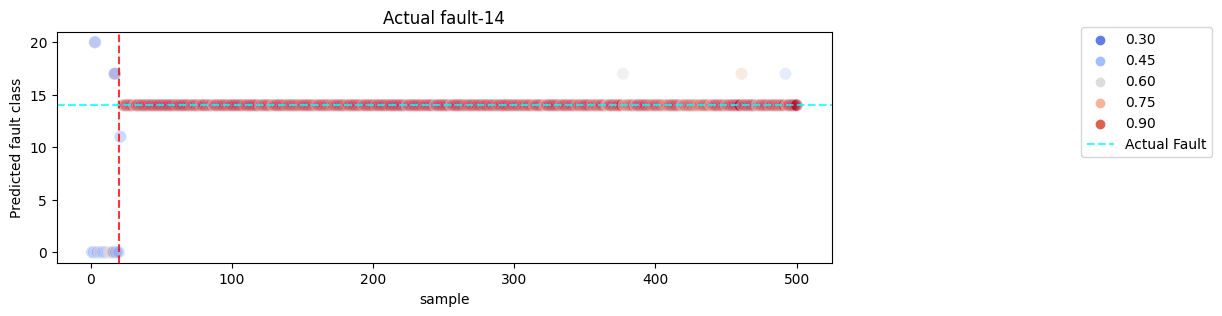

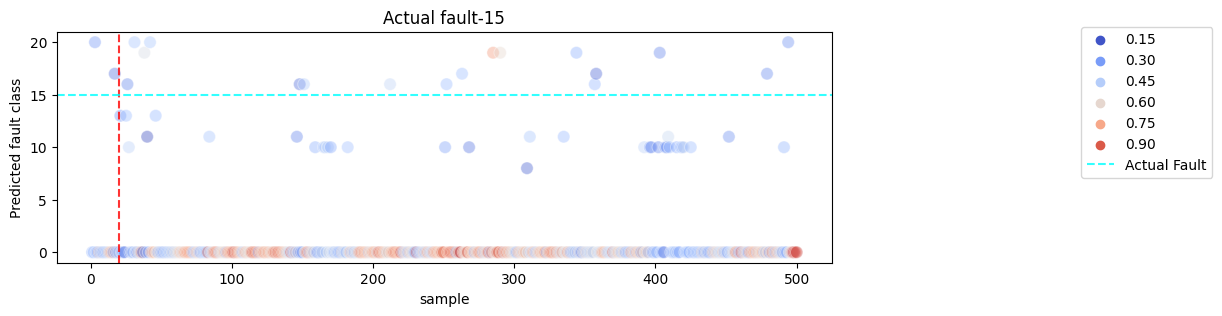

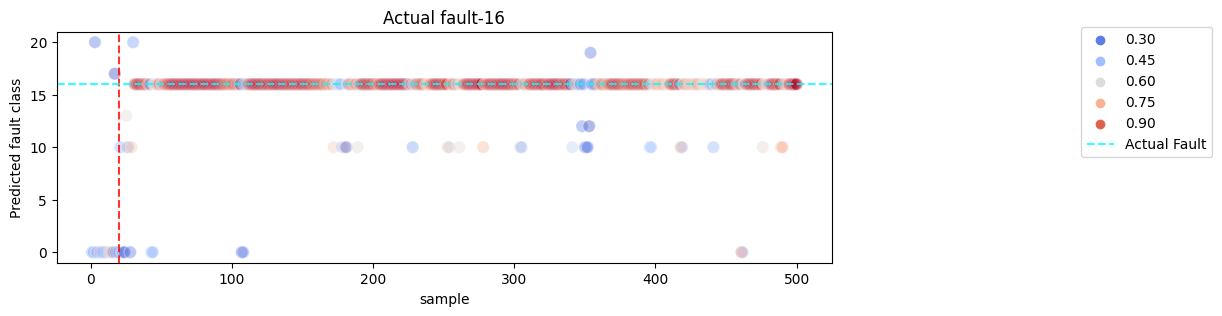

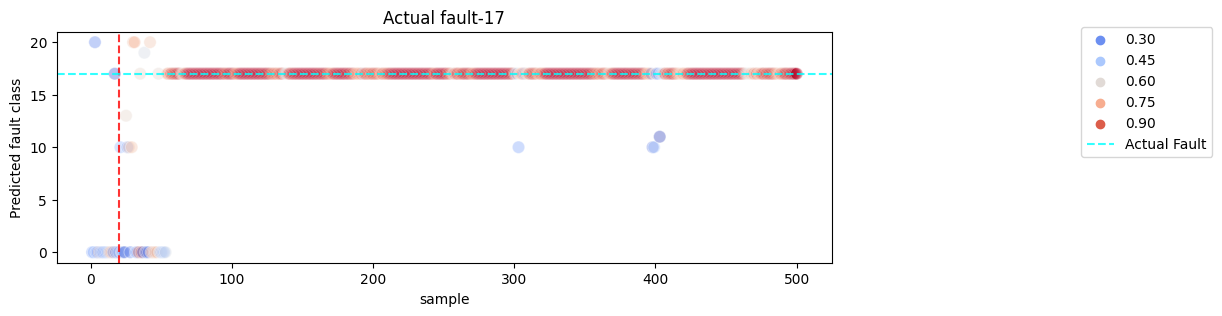

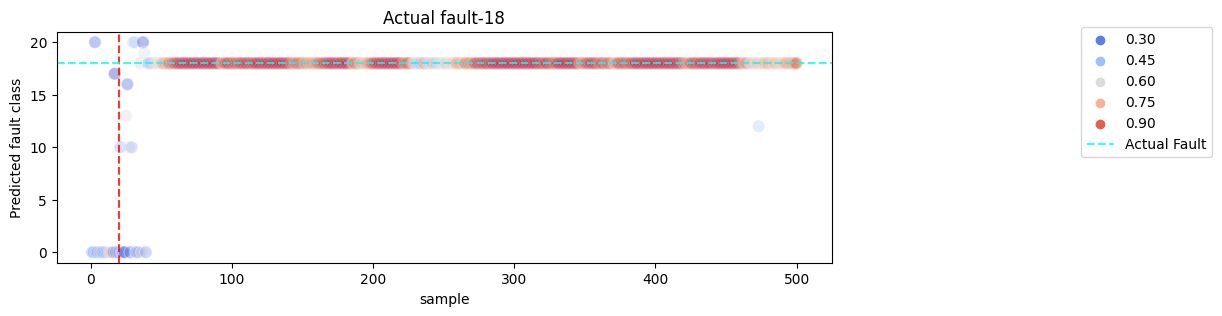

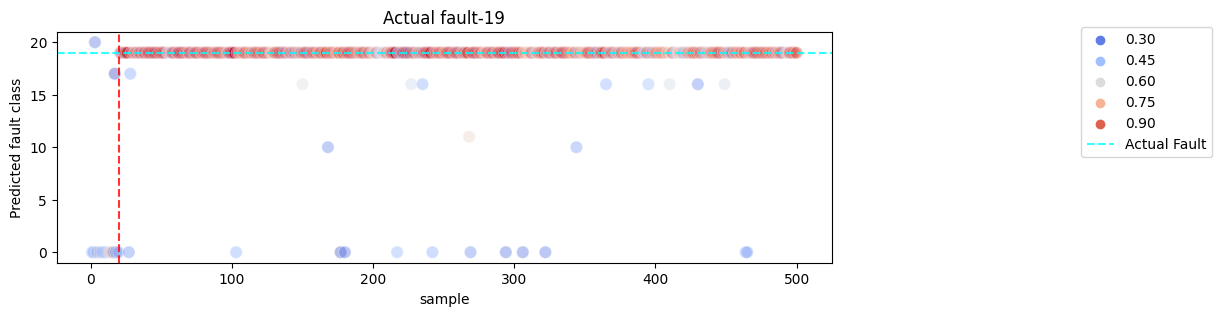

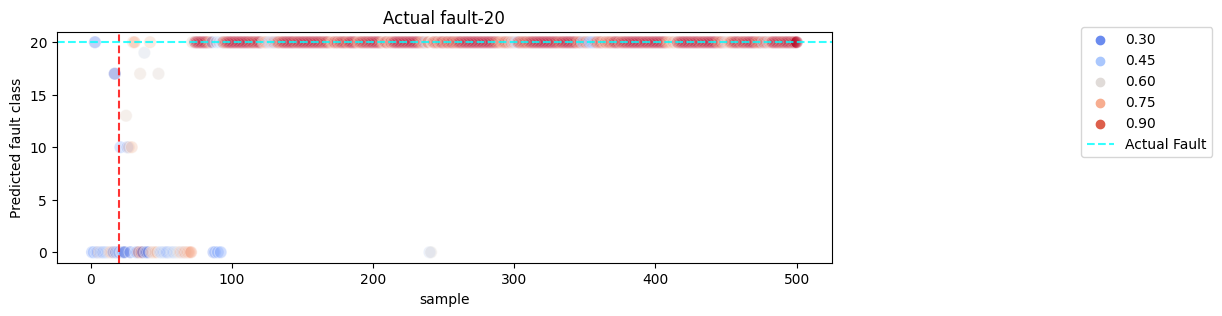

In [43]:
for F_num in range(0,21):
    df_new= DF[(DF['faultNumber']==F_num) & (DF['simulationRun']==2)]
    x_new = df_new.iloc[:,3:]
    x_new = sc.transform(x_new)

    x_nn = intermediate_model.predict(x_new,verbose=0)
    y_pred = rf.predict(x_nn)
    y_proba = np.max(rf.predict_proba(x_nn),axis=1)

    f, ax = plt.subplots(figsize=(10,3))
    
    sns.scatterplot(x=df_new['sample'],y=y_pred,hue=y_proba,palette="coolwarm",s=80,alpha=0.4)
    
    plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
    plt.axhline(F_num,c='cyan',alpha=0.8,label='Actual Fault',linestyle ='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.title(f'Actual fault-{F_num}')
    plt.show()

In [44]:
Accuracy=[]
for Fnum in [x for x in range(0,21) if x not in [3,9,15]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['sample']>20) & (DF['simulationRun']==np.random.randint(1,500))]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    y_true = temp_df['faultNumber']
    
    x_nn = intermediate_model.predict(X_faulty,verbose=0)
    y_pred = rf.predict(x_nn)
    
    
    acc = accuracy_score(y_true, y_pred)
    print(f'The accuracy for Fault_num={Fnum} is {acc}')
    
    Accuracy.append(acc)
print("#"*20)
print(f'The overall accuracy for Neural Net + RF is {np.mean(Accuracy)}')

The accuracy for Fault_num=0 is 0.95625
The accuracy for Fault_num=1 is 0.9958333333333333
The accuracy for Fault_num=2 is 0.9833333333333333
The accuracy for Fault_num=4 is 0.9895833333333334
The accuracy for Fault_num=5 is 0.9958333333333333
The accuracy for Fault_num=6 is 1.0
The accuracy for Fault_num=7 is 1.0
The accuracy for Fault_num=8 is 0.9520833333333333
The accuracy for Fault_num=10 is 0.9208333333333333
The accuracy for Fault_num=11 is 0.8708333333333333
The accuracy for Fault_num=12 is 0.8604166666666667
The accuracy for Fault_num=13 is 0.8458333333333333
The accuracy for Fault_num=14 is 0.9833333333333333
The accuracy for Fault_num=16 is 0.8729166666666667
The accuracy for Fault_num=17 is 0.9416666666666667
The accuracy for Fault_num=18 is 0.8708333333333333
The accuracy for Fault_num=19 is 0.9645833333333333
The accuracy for Fault_num=20 is 0.8625
####################
The overall accuracy for Neural Net + RF is 0.9370370370370371
